In [1]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 

import pax_lcls2016
from pax_deconvolve.deconvolution import deconvolvers

In [2]:
specs = pax_lcls2016.get_lcls_specs()

Text(0, 0.5, 'Intensity (a.u.)')

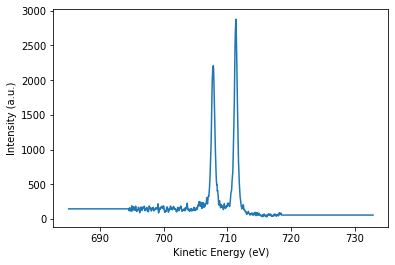

In [3]:
# Plot the measured Au 4f photoemission spectrum
plt.figure()
plt.plot(specs['psf']['x'], specs['psf']['y'])
plt.gca().set_xlabel('Kinetic Energy (eV)')
plt.gca().set_ylabel('Intensity (a.u.)')

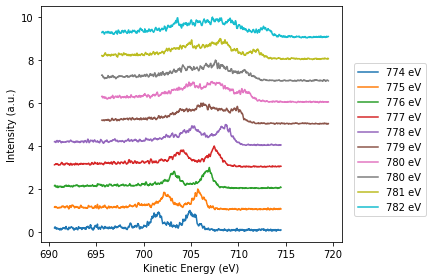

In [4]:
# Now plot the measured PAX spectra
plt.figure()
for ind, spec in enumerate(specs['spectra']):
    norm_spec = spec['y']/np.amax(spec['y'])
    offset = ind
    incident_photon_energy = specs['incident_photon_energy'][ind]
    label = ''.join([str(incident_photon_energy), ' eV'])
    plt.plot(spec['x'], norm_spec+offset, label=label)
plt.gcf().legend(loc=7)
plt.gca().set_xlabel('Kinetic Energy (eV)')
plt.gca().set_ylabel('Intensity (a.u.)')
plt.gcf().tight_layout()
plt.gcf().subplots_adjust(right=0.8)

In [ ]:
# Estimate best regularization parameter from data


In [5]:
# Deconvolve the PAX spectra
deconvolver_list = []
for ind, spec in enumerate(specs['spectra']):
    deconvolver = deconvolvers.LRFisterDeconvolve(
        specs['psf']['x'],
        specs['psf']['y']/np.sum(specs['psf']['y']),
        specs['spectra'][ind]['x'],
        regularization_strength=0.02,
        iterations=1000
    )
    test0 = spec['y']
    test = np.array([test0])
    _ = deconvolver.fit(test)
    deconvolver_list.append(deconvolver)

Automatic pdb calling has been turned ON


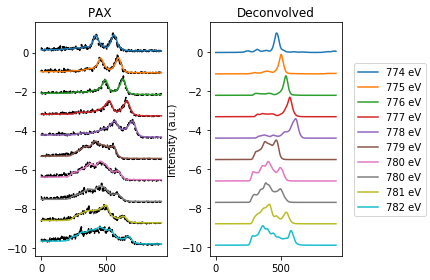

In [6]:
%pdb
# Make figure showing deconvolved results
f, axs = plt.subplots(1, 2)
for ind, deconvolved_spec in enumerate(deconvolver_list):
    incident_photon_energy = specs['incident_photon_energy'][ind]
    label = ''.join([str(incident_photon_energy), ' eV'])
    norm = np.amax(deconvolver_list[ind].measured_y_)
    axs[0].plot(-1.1*ind+deconvolver_list[ind].measured_y_/norm, 'k--')
    axs[0].plot(-1.1*ind+deconvolver_list[ind].reconstruction_y_/norm, label=label)
    norm = np.amax(deconvolver_list[ind].deconvolved_y_)
    axs[1].plot(-1.1*ind+deconvolver_list[ind].deconvolved_y_/norm)
axs[0].set_title('PAX ')
axs[1].set_title('Deconvolved')

plt.gcf().legend(loc=7)
#plt.gca().set_xlabel('Kinetic Energy (eV)')
plt.gca().set_ylabel('Intensity (a.u.)')
plt.gcf().tight_layout()
plt.gcf().subplots_adjust(right=0.8)